In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
        confusion_matrix, classification_report, roc_curve, auc
        )

In [2]:
data = load_breast_cancer()
X = data.data                # features
y = data.target              # labels: 0 (malignant) / 1 (benign)
feature_names = data.feature_names
target_names = data.target_names

print("Dataset shape:", X.shape)
print("Number of features:", len(feature_names))
print("Target names:", target_names)
print("\nFirst 5 rows of features:")
print(pd.DataFrame(X, columns=feature_names).head())

Dataset shape: (569, 30)
Number of features: 30
Target names: ['malignant' 'benign']

First 5 rows of features:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430

In [4]:
RANDOM_STATE = 42
TEST_SIZE = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (455, 30), Test shape: (114, 30)


In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [7]:
n_estimators = 100
learning_rate = 0.1
max_depth = 3

gbr = GradientBoostingRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=max_depth,
    random_state=RANDOM_STATE
    )

In [8]:
print("\nTraining GradientBoostingRegressor ... (this may take a few seconds)")
gbr.fit(X_train_scaled, y_train)
print("Training completed.")


Training GradientBoostingRegressor ... (this may take a few seconds)
Training completed.


In [9]:
y_test_pred_cont = gbr.predict(X_test_scaled)
y_test_pred_bin  = (y_test_pred_cont >= 0.5).astype(int)

# Also do on train set (useful for training-progress plots)
y_train_pred_cont = gbr.predict(X_train_scaled)
y_train_pred_bin  = (y_train_pred_cont >= 0.5).astype(int)

In [10]:
acc  = accuracy_score(y_test, y_test_pred_bin)
prec = precision_score(y_test, y_test_pred_bin, zero_division=0)
rec  = recall_score(y_test, y_test_pred_bin, zero_division=0)
f1   = f1_score(y_test, y_test_pred_bin, zero_division=0)
cm   = confusion_matrix(y_test, y_test_pred_bin)

print("\n=== Final Evaluation on TEST SET ===")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_bin, target_names=target_names, zero_division=0))

# ROC AUC (use continuous predictions)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_cont)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC : {roc_auc:.4f}")


=== Final Evaluation on TEST SET ===
Accuracy : 0.9386
Precision: 0.9452
Recall   : 0.9583
F1-score : 0.9517

Confusion Matrix:
 [[38  4]
 [ 3 69]]

Classification Report:
               precision    recall  f1-score   support

   malignant       0.93      0.90      0.92        42
      benign       0.95      0.96      0.95        72

    accuracy                           0.94       114
   macro avg       0.94      0.93      0.93       114
weighted avg       0.94      0.94      0.94       114

ROC AUC : 0.9914


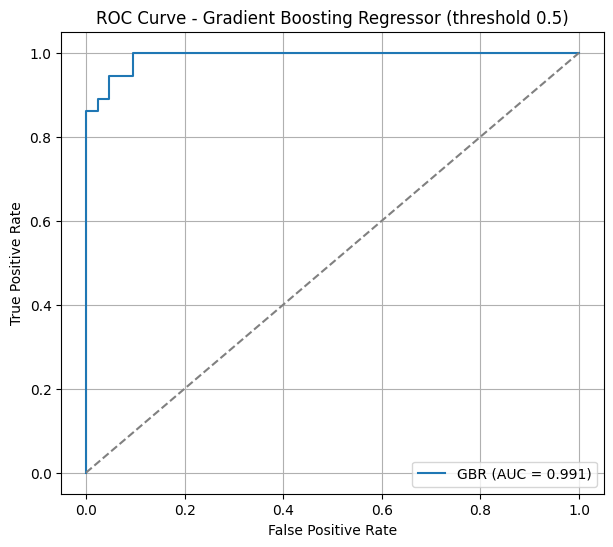

In [11]:
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f'GBR (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting Regressor (threshold 0.5)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

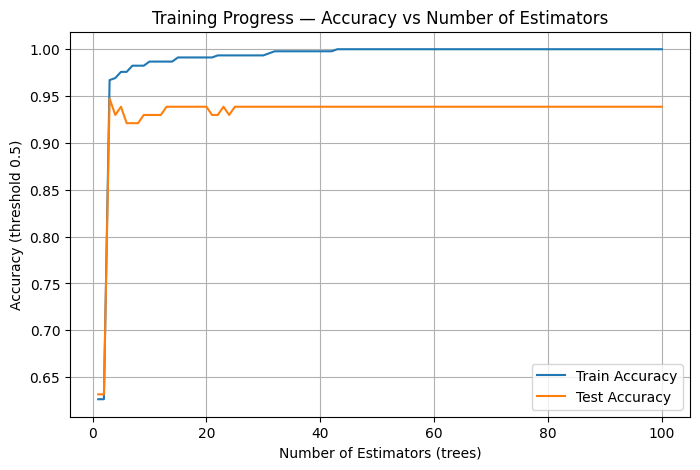

In [14]:
train_acc_list = []
test_acc_list  = []

# Note: staged_predict yields predictions after each boosting stage (1..n_estimators)
for y_train_pred_stage in gbr.staged_predict(X_train_scaled):
    y_train_bin_stage = (y_train_pred_stage >= 0.5).astype(int)
    train_acc_list.append(accuracy_score(y_train, y_train_bin_stage))

for y_test_pred_stage in gbr.staged_predict(X_test_scaled):
  y_test_bin_stage = (y_test_pred_stage >= 0.5).astype(int)
  test_acc_list.append(accuracy_score(y_test, y_test_bin_stage))
# Plot training progress (accuracy vs number of estimators)
plt.figure(figsize=(8, 5))
estimators_range = np.arange(1, n_estimators + 1)
plt.plot(estimators_range, train_acc_list, label='Train Accuracy')
plt.plot(estimators_range, test_acc_list, label='Test Accuracy')
plt.xlabel('Number of Estimators (trees)')
plt.ylabel('Accuracy (threshold 0.5)')
plt.title('Training Progress — Accuracy vs Number of Estimators')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
feat_importances = gbr.feature_importances_
fi_df = pd.DataFrame({
    'feature': feature_names,
        'importance': feat_importances
        }).sort_values('importance', ascending=False)

print("\nTop 10 features by importance:")
print(fi_df.head(10).to_string(index=False))


Top 10 features by importance:
             feature  importance
        worst radius    0.441971
     worst perimeter    0.182712
worst concave points    0.111925
 mean concave points    0.093961
       worst texture    0.040392
          worst area    0.031750
       texture error    0.027672
     worst concavity    0.012128
          area error    0.009636
        mean texture    0.008679


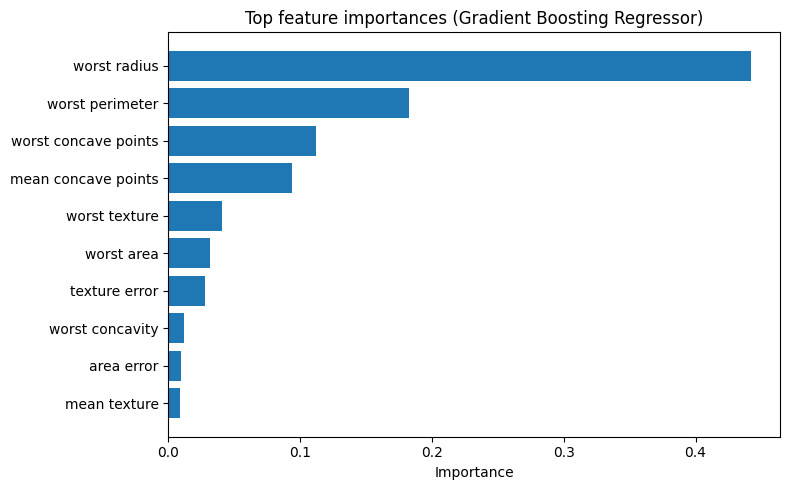

In [17]:
# Optional: Plot top 10
top_k = min(10, len(feature_names))
plt.figure(figsize=(8, 5))
plt.barh(fi_df['feature'].head(top_k)[::-1], fi_df['importance'].head(top_k)[::-1])
plt.xlabel('Importance')
plt.title('Top feature importances (Gradient Boosting Regressor)')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.tree import DecisionTreeRegressor
print("\n--- Manual demonstration of first 5 boosting iterations (conceptual) ---")
# initialize predictions with mean
y_pred_init = np.full_like(y_train, fill_value=np.mean(y_train), dtype=float)
print("Initial mean prediction (train):", np.mean(y_train))

# iterate and fit weak learners on residuals for 5 steps
manual_preds = y_pred_init.copy()
for i in range(5):
    residuals = y_train - manual_preds
    stump = DecisionTreeRegressor(max_depth= max_depth, random_state=RANDOM_STATE)
    stump.fit(X_train_scaled, residuals)
    update = stump.predict(X_train_scaled)
    manual_preds = manual_preds + learning_rate * update
    # compute train accuracy after thresholding
    manual_bin = (manual_preds >= 0.5).astype(int)
    acc_i = accuracy_score(y_train, manual_bin)
    print(f"Iteration {i+1} — train accuracy (after threshold): {acc_i:.4f}")

print("\n✅ End of Gradient Boosting experiment.")



--- Manual demonstration of first 5 boosting iterations (conceptual) ---
Initial mean prediction (train): 0.6263736263736264
Iteration 1 — train accuracy (after threshold): 0.6264
Iteration 2 — train accuracy (after threshold): 0.6264
Iteration 3 — train accuracy (after threshold): 0.9670
Iteration 4 — train accuracy (after threshold): 0.9692
Iteration 5 — train accuracy (after threshold): 0.9758

✅ End of Gradient Boosting experiment.
